# COVerage: Region-Specific SARS-CoV-2 News Query Algorithm 
![Searching GIF](https://thumbs.gfycat.com/BlaringGaseousEsok-small.gif)
Searching gif https://gfycat.com/blaringgaseousesok

In [1]:
# One time run - installs dependencies

import matplotlib.pyplot as plt
from newspaper import fulltext
from nltk.corpus import wordnet
import math
import requests
import numpy as np
import pandas as pd 
from IPython.display import display, HTML
from GoogleNews import GoogleNews
from rank_bm25 import BM25Okapi



In [2]:
def lavaa_extractive(query, url):
    lavaa = 0
    text = (fulltext(requests.get(url).text)).replace("\n", " ")

    query_words = query.split()
    text_words = text.split()
    text_words_len = len(text_words)
    for word in text_words:
        if word in query_words:
            lavaa += 1
    s_query = 10*(lavaa/text_words_len)
    return 1 / (1 + math.exp(-s_query))

def lavaa_abstractive(query, url):
    syn = list()
    query_words = query.split()
    for word in query_words:
        if word != "news":
            for synset in wordnet.synsets(word):
               for lemma in synset.lemmas():
                  syn.append(lemma.name())
            
    lavaa = 0
    try:
        text = (fulltext(requests.get(url).text)).replace("\n", " ")
    except:
        return 0
    text_words = text.split()
    text_words_len = len(text_words)
    for word in text_words:
        if word in query_words or word in syn:
            lavaa += 1
    s_query = 10*(lavaa/text_words_len)

    return 1 / (1 + math.exp(-s_query))

In [3]:
def bm25_metric(query, url):
    try:
        text = (fulltext(requests.get(url).text)).replace("\n", " ")
    except:
        return 0
    text_corpus = text.split()
    bm25 = BM25Okapi(text_corpus)
    query_tokens = query.split(" ")
    doc_scores = bm25.get_scores(query_tokens)
    return doc_scores
from rank_bm25 import BM25Okapi

corpus = [
    "Hello there good man!",
    "It is quite windy in London",
    "How is the weather today?"
]

def get_corpus(query):
    url_1, url_2, url_3 = query_urls(query)
    url_list = [url_1, url_2, url_3]
    corpus = []
    for url in url_list:
        text = (fulltext(requests.get(url).text)).replace("\n", " ")
        corpus.append(text)
    return corpus


# Google News BM25 Result
def bm25_metric(query):
    corpus = get_corpus(query)
    corpus_tokens = [text.split(" ") for text in corpus]
    bm25 = BM25Okapi(corpus_tokens)


    tokenized_query = query.split(" ")

    doc_scores = bm25.get_scores(tokenized_query)
    return doc_scores



In [4]:
# Google News Query

def query_urls(query):
    urls = []
    googlenews = GoogleNews()
    googlenews.setlang('en')
    googlenews.search(query)
    results = googlenews.result()
    limit = 3
    counter = 0
    url_counter = 0
    while counter < limit:
        url = results[url_counter]['link']
        url_counter += 1
        try:
            text = (fulltext(requests.get(url).text)).replace("\n", " ")
            if len(text.split()) > 50:
                urls.append(url)
                counter += 1
        except:
            continue
    return urls[0], urls[1], urls[2]



In [5]:
# URL's determined by Google News search algorithm

query1 = "Manhattan, NY coronavirus vaccine news"
url1_1, url1_2, url1_3 = query_urls(query1)

query2 = "Manhattan, NY COVID-19 medicine"
url2_1, url2_2, url2_3 = query_urls(query2)

query3 = "Manhattan, NY COVID-19 biology"
url3_1, url3_2, url3_3 = query_urls(query3)

score1_1 = lavaa_abstractive(query1, url1_1)
score1_2 = lavaa_abstractive(query1, url1_2)
score1_3 = lavaa_abstractive(query1, url1_3)
score2_1 = lavaa_abstractive(query2, url2_1)
score2_2 = lavaa_abstractive(query2, url2_2)
score2_3 = lavaa_abstractive(query2, url2_3)
score3_1 = lavaa_abstractive(query3, url3_1)
score3_2 = lavaa_abstractive(query3, url3_2)
score3_3 = lavaa_abstractive(query3, url3_3)

score1_vals = [score1_1, score1_2, score1_3]
score2_vals = [score2_1, score2_2, score2_3]
score3_vals = [score3_1, score3_2, score3_3]

In [6]:
def visualization(queries, score_vals):
    query1 = queries[0]
    query2 = queries[1]
    query3 = queries[2]
    
    score1_vals = score_vals[0]
    score2_vals = score_vals[1]
    score3_vals = score_vals[2]
    
    col1_vals = [score1_vals[0], score2_vals[0], score3_vals[0]]
    col2_vals = [score1_vals[1], score2_vals[1], score3_vals[1]]
    col3_vals = [score1_vals[2], score2_vals[2], score3_vals[2]]

    index = np.arange(3)
    width = 0.20
    fig = plt.figure()
    ax = fig.add_subplot(111)

    col1 = ax.bar(index, col1_vals, width, color='b')
    col2 = ax.bar(index+width, col2_vals, width, color='cornflowerblue')
    col3 = ax.bar(index+width*2, col3_vals, width, color='lightsteelblue')

    ax.set_ylabel('COVerage Local Query Metric (LQM)')
    ax.set_xlabel('Queries')
    ax.set_xticks(index+width)
    ax.set_ylim(0.0, 1.0)
    ax.set_xticklabels((query1, query2, query3), rotation=15)
    ax.legend((col1[0], col2[0], col3[0]), ('First result of Google News search', 'Second result of Google News search', 'Third result of Google News search'))
    plt.show()

    score1_av = sum(score1_vals) / len(score1_vals)
    score2_av = sum(score2_vals) / len(score2_vals)
    score3_av = sum(score3_vals) / len(score3_vals)
    scores_av = [score1_av, score2_av, score3_av]

    # Calling DataFrame constructor after zipping 
    # both lists, with columns specified 
    
    data_frame = pd.DataFrame(list(zip(queries, scores_av)), 
               columns =['Query', 'Average LQM'], index = ['1', '2', '3']) 

    display(data_frame)
    
def bm25_visualization(queries):
    query1 = queries[0]
    query2 = queries[1]
    query3 = queries[2]
    
    
    
    score1_vals = bm25_metric(query1)
    score2_vals = bm25_metric(query2)
    score3_vals = bm25_metric(query3)
    
    col1_vals = [score1_vals[0], score2_vals[0], score3_vals[0]]
    col2_vals = [score1_vals[1], score2_vals[1], score3_vals[1]]
    col3_vals = [score1_vals[2], score2_vals[2], score3_vals[2]]

    index = np.arange(3)
    width = 0.20
    fig = plt.figure()
    ax = fig.add_subplot(111)

    col1 = ax.bar(index, col1_vals, width, color='rebeccapurple')
    col2 = ax.bar(index+width, col2_vals, width, color='blueviolet')
    col3 = ax.bar(index+width*2, col3_vals, width, color='mediumpurple')

    ax.set_ylabel('BM25')
    ax.set_xlabel('Queries')
    ax.set_xticks(index+width)
    ax.set_xticklabels((query1, query2, query3), rotation=15)
    ax.legend((col1[0], col2[0], col3[0]), ('First result of Google News search', 'Second result of Google News search', 'Third result of Google News search'))
    plt.show()

    score1_av = sum(score1_vals) / len(score1_vals)
    score2_av = sum(score2_vals) / len(score2_vals)
    score3_av = sum(score3_vals) / len(score3_vals)
    scores_av = [score1_av, score2_av, score3_av]

    # Calling DataFrame constructor after zipping 
    # both lists, with columns specified 
    
    data_frame = pd.DataFrame(list(zip(queries, scores_av)), 
               columns =['Query', 'Average BM25'], index = ['1', '2', '3']) 

    display(data_frame)

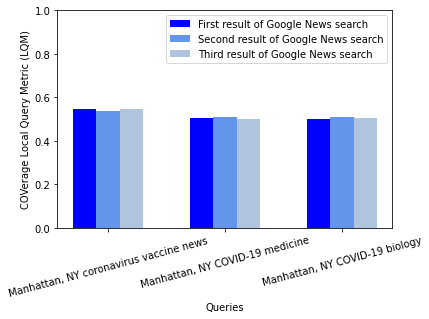

,Query,Average LQM
1,"Manhattan, NY coronavirus vaccine news",0.544939
2,"Manhattan, NY COVID-19 medicine",0.505336
3,"Manhattan, NY COVID-19 biology",0.505839


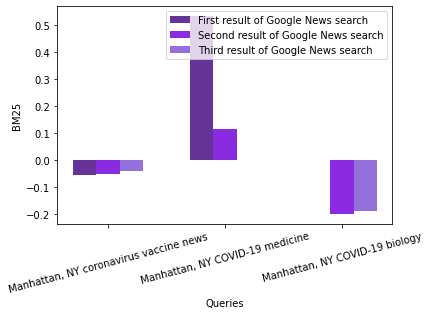

,Query,Average BM25
1,"Manhattan, NY coronavirus vaccine news",-0.049088
2,"Manhattan, NY COVID-19 medicine",0.216157
3,"Manhattan, NY COVID-19 biology",-0.129544


In [7]:
visualization([query1, query2, query3], [score1_vals, score2_vals, score3_vals])
bm25_visualization([query1, query2, query3])

In [8]:
query1_2 = "International coronavirus vaccine news"
url1_1_2, url1_2_2, url1_3_2 = query_urls(query1_2)

query2_2 = "Global COVID-19 medicine"
url2_1_2, url2_2_2, url2_3_2 = query_urls(query2_2)

query3_2 = "International COVID-19 biology"
url3_1_2, url3_2_2, url3_3_2 = query_urls(query3_2)

score1_1_2 = lavaa_abstractive(query1_2, url1_1_2)
score1_2_2 = lavaa_abstractive(query1_2, url1_2_2)
score1_3_2 = lavaa_abstractive(query1_2, url1_3_2)
score2_1_2 = lavaa_abstractive(query2_2, url2_1_2)
score2_2_2 = lavaa_abstractive(query2_2, url2_2_2)
score2_3_2 = lavaa_abstractive(query2_2, url2_3_2)
score3_1_2 = lavaa_abstractive(query3_2, url3_1_2)
score3_2_2 = lavaa_abstractive(query3_2, url3_2_2)
score3_3_2 = lavaa_abstractive(query3_2, url3_3_2)

score1_vals_2 = [score1_1_2, score1_2_2, score1_3_2]
score2_vals_2 = [score2_1_2, score2_2_2, score2_3_2]
score3_vals_2 = [score3_1_2, score3_2_2, score3_3_2]

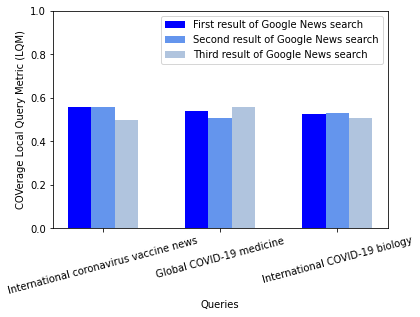

,Query,Average LQM
1,International coronavirus vaccine news,0.540146
2,Global COVID-19 medicine,0.536066
3,International COVID-19 biology,0.523415


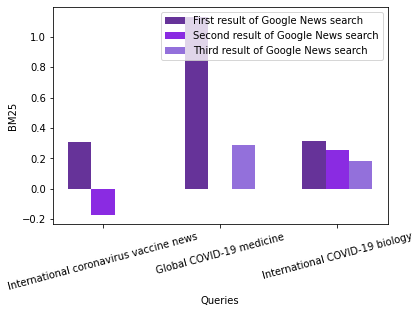

,Query,Average BM25
1,International coronavirus vaccine news,0.045450
2,Global COVID-19 medicine,0.471639
3,International COVID-19 biology,0.249231


In [9]:
visualization([query1_2, query2_2, query3_2], [score1_vals_2, score2_vals_2, score3_vals_2])
bm25_visualization([query1_2, query2_2, query3_2])